In [14]:
import numpy as np
import pandas as pd
import json
import folium
from branca.colormap import linear
from matplotlib import pyplot as plt

In [2]:
%qtconsole
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pandas df

In [108]:
postal_count = pd.read_csv('/media/flo/Stockage/Data/MesAides/tables/postal_count.csv')
del postal_count['Unnamed: 0']

In [109]:
postal_count.head(2)

,Code_commune_INSEE,CP_count
0,50173,0
1,06079,0


In [110]:
postal_count_dict = postal_count.set_index('Code_commune_INSEE')['CP_count']
postal_count_dict = postal_count_dict.to_dict()
postal_count_dict['65405']

0.0

In [111]:
postal_count.Code_commune_INSEE = postal_count.Code_commune_INSEE.astype(str)
postal_count.CP_count = postal_count.CP_count.astype(int)

### GeoJSON

In [75]:
geo_json_data = json.load(open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json'))

### Map

In [ ]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)
folium.GeoJson(geo_json_data).add_to(map_france)
map_france

In [ ]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)
map_france.choropleth(geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read())
map_france.save('/media/flo/Stockage/Data/MesAides/map/TESTMAP.html')

In [43]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(map_france)

map_france.save('/media/flo/Stockage/Data/MesAides/map/geojson_test2.html')

In [79]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': colormap(postal_count_dict[feature["geometry.properties.insee"]]),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : .9,
        }
    ).add_to(map_france)

map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_test1.html')

KeyError: 'geometry.properties.insee'

## Choropleth

In [202]:
postal_count[postal_count.CP_count != 0].sort_values(by='CP_count', ascending=False).head()

,Code_commune_INSEE,CP_count
220,31555,1249
877,44109,910
18,34172,823
3139,33063,733
1339,67482,723


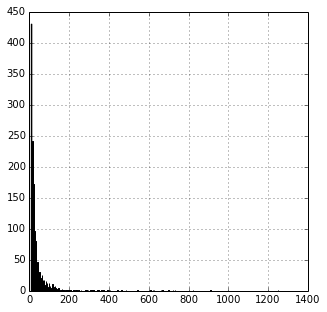

In [17]:
postal_count.CP_count[postal_count.CP_count > 10].hist(bins=500, figsize=(5, 5))

In [19]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(
                    geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read(),
                    data=postal_count,
                    columns=['Code_commune_INSEE', 'CP_count'],
                    key_on='feature.properties.insee',
                    fill_color='BuPu',
                    line_opacity=0.05,
                    line_weight=0.3,
                    line_color='grey',
                    threshold_scale=[10.0, 50.0, 90.0, 150.0, 200.0, 500.0],
                    legend_name='Nombre de simulations',
)
map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_test1.html')

In [20]:
# map_france
# voir le HTML dictement.

### Choropleth normalisé par la population par code_insee

In [112]:
# recencement 2013
t_populations = pd.read_excel('/media/flo/Stockage/Data/communes_osm/population_communes_insee/ensemble.xls',
                              skiprows=7,
                              sheetname='Communes',
                              converters={'Code région': str, 'Code commune': str, 'Code département': str}
                             )
# code insee = code département & code commune
t_populations['Code_commune_INSEE'] = t_populations[['Code département', 'Code commune']].astype(str).sum(axis=1)

t_populations.head(2)

,Code région,Nom de la région,Code département,Code arrondissement,Code canton,Code commune,Nom de la commune,Population municipale,Population comptée à part,Population totale,Code_commune_INSEE
0,82,Rhône-Alpes,01,2,8,001,L' Abergement-Clémenciat,767,13,780,01001
1,82,Rhône-Alpes,01,1,1,002,L' Abergement-de-Varey,236,4,240,01002


In [113]:
postal_count = pd.merge(postal_count,
               t_populations.ix[:, ['Code_commune_INSEE', 'Population totale', 'Nom de la commune']],
               on='Code_commune_INSEE',
               how='left')

postal_count.head(2)

,Code_commune_INSEE,CP_count,Population totale,Nom de la commune
0,50173,0,17841,Équeurdreville-Hainneville
1,06079,0,23095,Mandelieu-la-Napoule


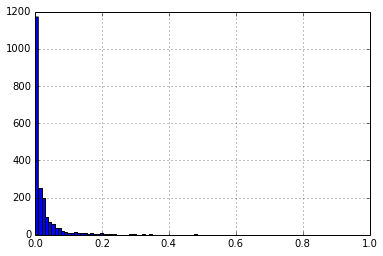

In [114]:
postal_count['ratio'] = postal_count['CP_count'] / postal_count['Population totale']
postal_count[postal_count.CP_count > 10].ratio.hist(bins=100)

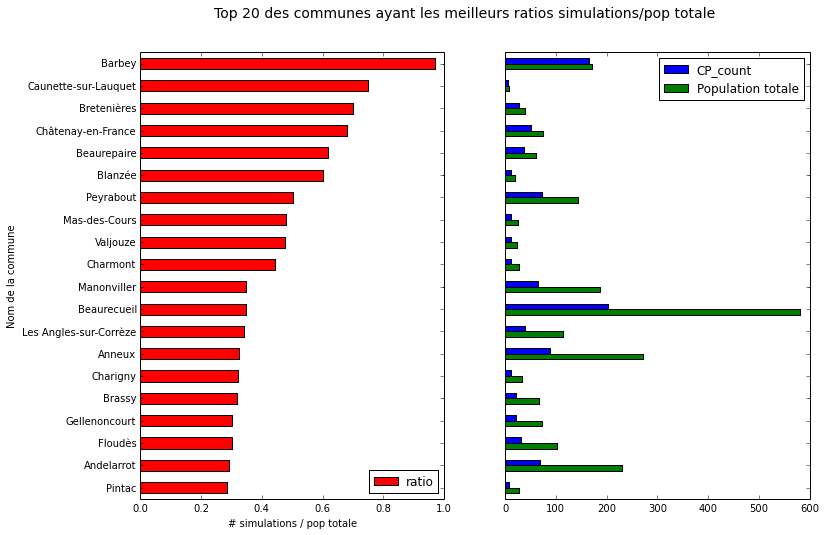

In [205]:
fig = plt.figure(figsize=(12, 8))
ax0 = plt.subplot(121)
postal_count.sort_values('ratio', ascending=False).head(20).plot(kind='barh',
                                                                 x='Nom de la commune',
                                                                 y='ratio',
                                                                 ax=ax0,
                                                                 color='red')
plt.gca().invert_yaxis()
plt.xlabel('# simulations / pop totale')
plt.legend(loc='lower right')

ax1 = plt.subplot(122, sharey=ax0)
postal_count.sort_values('ratio', ascending=False).head(20).plot(kind='barh',
                                                                 x='Nom de la commune',
                                                                 y=['CP_count', 'Population totale'],
                                                                 ax=ax1)

plt.gca().invert_yaxis()

plt.suptitle('Top 20 des communes ayant les meilleurs ratios simulations/pop totale', fontsize=14)

In [121]:
from folium.utilities import split_six

In [40]:
postal_count_filter = postal_count.copy()

In [48]:
postal_count_filter.loc[(postal_count_filter['Population totale'] > 5000) & postal_count_filter['Population totale'] < 20000]['ratio'] =  -1

In [49]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(
                    geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read(),
                    data=postal_count,
                    columns=['Code_commune_INSEE', 'ratio'],
                    key_on='feature.properties.insee',
                    fill_color='RdPu',
                    line_opacity=0.05,
                    fill_opacity=0.8,
                    line_weight=0.3,
                    line_color='grey',
                    #threshold_scale=[0.015, 0.05, 0.1, 0.2, 0.3, 0.5],
                    legend_name='Nombre de simulations normalisé par la population'
)
map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_ratio_f5000.html')

## Indice pauvreté

In [57]:
%qtconsole

In [115]:
# recencement 2013
t_pauvrete = pd.read_excel('/media/flo/Stockage/Data/communes_osm/pauvrete_insee/base-cc-filosofi-12.xls',
                              skiprows=5,
                              sheetname='COM',
                              converters={'CODGEO': str, 'LIBGEO': str}
                             )
t_pauvrete.rename(columns={'CODGEO': 'Code_commune_INSEE',
                           'NBMENFISC12': 'nb_menages_fiscaux',
                           'NBPERSMENFISC12': 'nb_pers_menages_fiscaux'}, inplace=True)
t_pauvrete.head(2)

,Code_commune_INSEE,LIBGEO,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12,PIMP12,TP6012,TP60AGE112,TP60AGE212,TP60AGE312,...,PPEN12,PPAT12,PPSOC12,PPFAM12,PPMINI12,PPLOGT12,PIMPOT12,RD12,D112,D912
0,01001,L'Abergement-Clémenciat,299,780.5,22253.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01002,L'Abergement-de-Varey,97,227.0,21765.714286,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
t_pauvrete = t_pauvrete.ix[:, ['Code_commune_INSEE', 'nb_menages_fiscaux', 'nb_pers_menages_fiscaux', 'MED12']]
t_pauvrete.head()

,Code_commune_INSEE,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12
0,01001,299,780.5,22253.000000
1,01002,97,227.0,21765.714286
2,01004,5897,13420.0,19236.666667
3,01005,615,1673.5,21743.888889
4,01006,48,111.0,20354.400000


In [117]:
postal_count = pd.merge(postal_count, t_pauvrete, on='Code_commune_INSEE', how='left')
postal_count.head(2)

,Code_commune_INSEE,CP_count,Population totale,Nom de la commune,ratio,nb_menages_fiscaux,nb_pers_menages_fiscaux,MED12
0,50173,0,17841,Équeurdreville-Hainneville,0,7309,16766.5,19459.500000
1,06079,0,23095,Mandelieu-la-Napoule,0,11938,23629.5,21251.904762


In [131]:
postal_count.CP_count.corr(postal_count.MED12)

0.046293425093771066

In [119]:
postal_count.fillna(-1, inplace=True)

In [132]:
map_france = folium.Map(location=[47.000000, 2.000000], zoom_start=6)

map_france.choropleth(
                    geo_str=open('/media/flo/Stockage/Data/communes_osm/communes_100m/simplified_communes100m.json').read(),
                    data=postal_count,
                    columns=['Code_commune_INSEE', 'MED12'],
                    key_on='feature.properties.insee',
                    fill_color='RdPu',
                    line_opacity=0.05,
                    fill_opacity=0.8,
                    line_weight=0.3,
                    line_color='grey',
                    #threshold_scale=[0.015, 0.05, 0.1, 0.2, 0.3, 0.5],
                    legend_name='MED12'
)
map_france.save('/media/flo/Stockage/Data/MesAides/map/choro_MED12.html')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


In [160]:
postal_count_0 = postal_count.loc[postal_count.ratio > 0.01]

In [161]:
postal_count_0.CP_count.corr(postal_count_0.MED12)

0.26256485861445178

In [166]:
postal_count.loc[postal_count.ratio > 0.01].count()

Code_commune_INSEE         1774
CP_count                   1774
Population totale          1774
Nom de la commune          1774
ratio                      1774
nb_menages_fiscaux         1774
nb_pers_menages_fiscaux    1774
MED12                      1774
dtype: int64

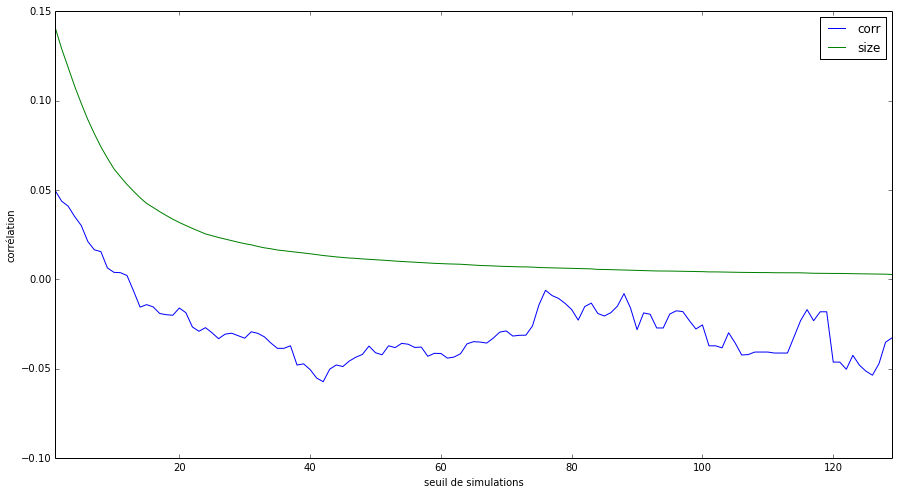

In [233]:
ratio_threshold = np.arange(1, 1000, 1)
l_corr = []
l_size = []
l_thresh = []
nb_communes = postal_count.shape[0] # nb communes initiales (31k)

for thresh in ratio_threshold:
    if (nb_communes > 100):
        postal_count_thresh = postal_count.loc[postal_count.CP_count >= thresh]
        corr = postal_count_thresh.CP_count.corr(postal_count_thresh.MED12)
        nb_communes = postal_count.loc[postal_count.CP_count >= thresh].shape[0]
        nb_communes_ratio = postal_count.loc[postal_count.CP_count >= thresh].shape[0] / postal_count.shape[0]
        l_corr.append(corr)
        l_size.append(nb_communes_ratio)
        l_thresh.append(thresh)
    else:
        break

df_res = pd.DataFrame()
df_res['corr'] = l_corr
df_res['size'] = l_size
df_res.index = l_thresh
df_res.plot(figsize=(15, 8))
plt.xlabel('seuil de simulations')
plt.ylabel('corrélation')
#pd.DataFrame(l_size).plot()